# Falcons tutorial
The basic usageof Falcons is explained here. Let's declare the use of the package as follows.

In [1]:
using Revise
using Falcons
using Plots
using Healpix
using PyPlot
pyplot()

┌ Info: Precompiling Falcons [eba0fb4b-2daf-4740-90d2-e5655143e0a0]
└ @ Base loading.jl:1317


Plots.PyPlotBackend()

## ScanningStrategy structure
Falcons has a `ScanningStrategy` structure.
It can be generated using the `gen_Scanning_Strategy` function.
Let's declare it as `ss`.

In [2]:
ss = gen_ScanningStrategy()
@show fieldnames(ScanningStrategy)
@show ss;

fieldnames(ScanningStrategy) = (:nside, :duration, :sampling_rate, :alpha, :beta, :prec_rpm, :spin_rpm, :hwp_rpm, :FP_theta, :FP_phi, :start_point, :start_angle)
ss = ScanningStrategy{Float64, Int64, Vector{Float64}, String}(128, 31536000, 1.0, 45.0, 50.0, 0.005198910308399359, 0.05, 0.0, [0.0], [0.0], "equator", 0.0)


The result of `@show fieldnames(ScanningStrategy)` shows the parameters that ScanningStrategy contains, and you can see that `ss` contains the value shown in the second line as the initial value.

Next, let's change the parameters of the `ScanningStrategy`.
There are two ways to change the value: by entering the value in the argument when declaring it, or by accessing ss later and changing it interactively.

In [3]:
# First method
#period2rpm(min) converts rotation period[min.] to rpm.
PrecessionPeriod_min = 4*60
ss = gen_ScanningStrategy(alpha=45, prec_rpm = period2rpm(PrecessionPeriod_min))
@show ss;

ss = ScanningStrategy{Float64, Int64, Vector{Float64}, String}(128, 31536000, 1.0, 45.0, 50.0, 0.004166666666666667, 0.05, 0.0, [0.0], [0.0], "equator", 0.0)


In [4]:
# Second method
ss.spin_rpm = 0.032
ss.beta = 50
@show ss;

ss = ScanningStrategy{Float64, Int64, Vector{Float64}, String}(128, 31536000, 1.0, 45.0, 50.0, 0.004166666666666667, 0.032, 0.0, [0.0], [0.0], "equator", 0.0)


## How to calculate pointing TOD
Plot the pointing TOD drawn by the boresight in 1 period.
`time_array` contains the time used in the calculation.

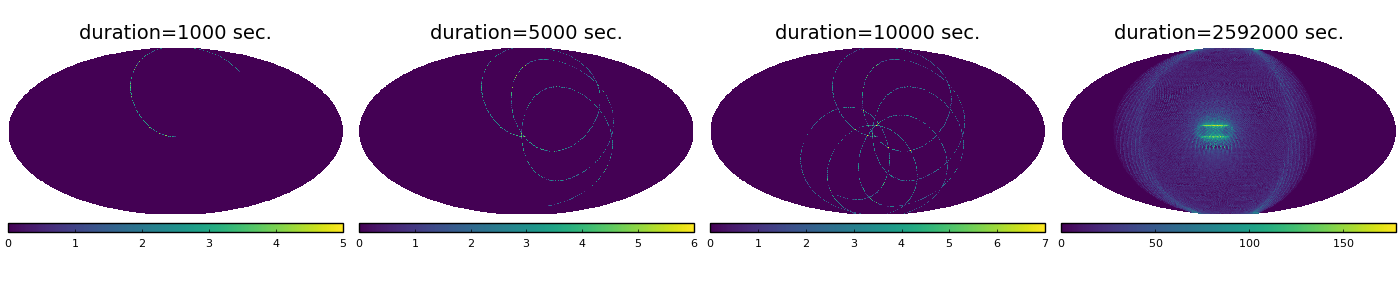

In [5]:
day = 60*60*24
time = [1000, 5000, 10000, 30day]
track = [HealpixMap{Float64, RingOrder}(ss.nside) for i in eachindex(time)]

for i in eachindex(time)
    pointings = get_pointings(ss, 0, time[i])
    track[i].pixels = angtod2hitmap(ss.nside, pointings["theta"], pointings["phi"])
end

plts = [Plots.plot(track[i], c=:viridis, title="duration="*"$(time[i]) sec.") for i in eachindex(time)]
Plots.plot(plts[1], plts[2], plts[3], plts[4], layout=(1,length(time)), size=(1400,300))

In [6]:
nmax = 5
outmap = get_hn_map(ss, division=6, nmax=nmax)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:21


Dict{String, Array} with 2 entries:
  "hitmap" => [310.0, 312.0, 314.0, 311.0, 391.0, 389.0, 386.0, 382.0, 388.0, 3…
  "h"      => ComplexF64[-0.00343144+0.139945im 0.392486-0.00140094im … 0.60358…

`outmap[1]` contains the result of the hitmap, as shown in the plot above.
`outmap[2]-[5]` contains the crosslink map corresponding to spin `n` as shown below.

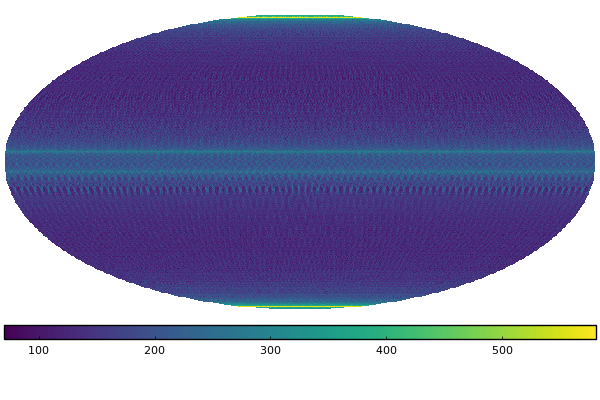

In [7]:
hitmap = HealpixMap{Float64, RingOrder}(ss.nside)
hitmap.pixels = outmap["hitmap"]
Plots.plot(hitmap, c=:viridis)

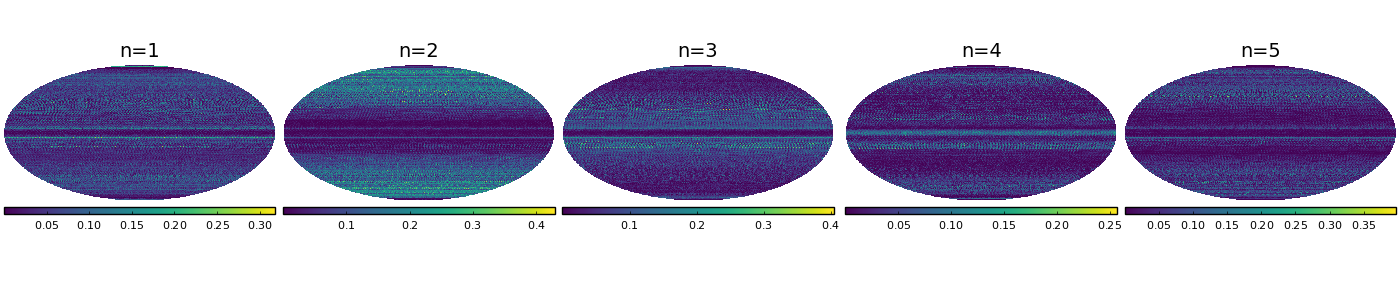

In [8]:
hmaps = [HealpixMap{Float64, RingOrder}(ss.nside) for i in 1:nmax]

for i in 1:nmax
    hmaps[i].pixels = outmap["h"][:,i] .|> abs2
end

hn_fig = [Plots.plot(hmaps[i], c=:viridis, title="n=$i") for i in 1:nmax]
    
Plots.plot(hn_fig[1], hn_fig[2], hn_fig[3], hn_fig[4], hn_fig[5], layout=(1,nmax), size=(1400,300))

## Multi-channel calculations
If you want to observe more than one detector channel, just add values to the `FP_theta` and `FP_phi` arrays.
In the example below, the pointing is only 5 degrees off in the direction of $\theta$ from the boresight.
It is also possible to configure a focal plane by entering focal plane configuration.

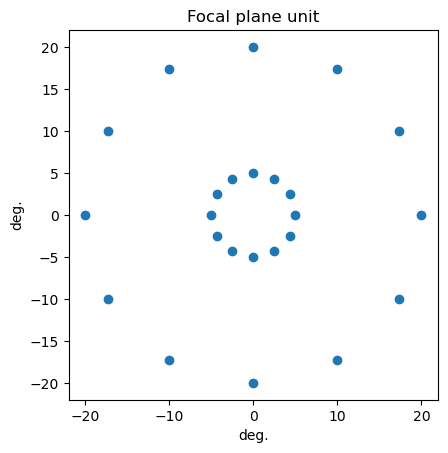

In [9]:
fake_focalplane_theta = []
fake_focalplane_phi = []
k = 1
for i in 5:15:30
    for j in 0:30:360-30
        push!(fake_focalplane_theta, i)
        push!(fake_focalplane_phi, j)
        k += 1
    end
end

ss.FP_theta = fake_focalplane_theta
ss.FP_phi = fake_focalplane_phi
x = @. ss.FP_theta * cosd(ss.FP_phi)
y = @. ss.FP_theta * sind(ss.FP_phi);

plt.axes().set_aspect("equal")
plt.plot(x,y, "o")
plt.title("Focal plane unit")
plt.xlabel("deg.")
plt.ylabel("deg.");

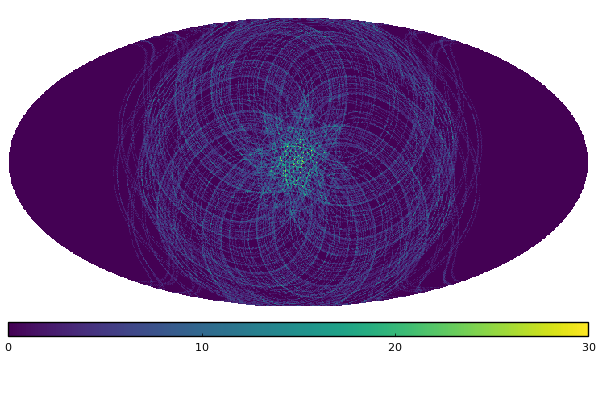

In [10]:
pointings = get_pointings(ss, 0, PrecessionPeriod_min*60)
multi_track_map = angtod2hitmap(ss.nside, pointings["theta"], pointings["phi"])
hitmap = HealpixMap{Float64, RingOrder}(ss.nside)
hitmap.pixels = multi_track_map
Plots.plot(hitmap, c=:viridis)